This work was done with Eric Cho. The interaction between media and stock market is a hot topic, which has received a lot of attention in the finance literature. In this post, I will utilize Latent Dirichlet Allocation (LDA) method to isolate out different topic in Korean news papers and how it interacts with the stock market activity. For this post, I will be looking at news articles related to Kia Motors (A000270).

The dataset consists of 8,118 posts extracted from [Paxnet](https://www.paxnet.co.kr/) between January 2018 until Dec 27th 2020. I won’t go into detail regarding the code used to scrape the news articles, but it is as follows.



In [1]:
import requests
import time
import os
from bs4 import BeautifulSoup
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import NewsNounExtractor
from soynlp.tokenizer import LTokenizer
import collections
import re
import gensim
import datetime
from pandas_datareader.data import DataReader
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.chdir(# insert path of directory)
stockcode = 'A000270'
collected_article = []
page_no = 1
cont = True
while cont:
    req = requests.get(f'http://www.paxnet.co.kr/news/{stockcode[1:]}/stock?currentPageNo={page_no}&stockCode={stockcode[1:]}')
    soup = BeautifulSoup(req.content.decode('utf8'),"html.parser")
    article_list = soup.find('div',attrs={'class':'board-thumbnail'}).findAll('li')
    for i,article in enumerate(article_list[:20]):
        link = article.find('dl',attrs={'class':'text'}).find('dt').find('a')['href'].split("¤")[0]
        articleId = link.split("articleId=")[1]
        if int(articleId[:4])<2018: #Ex
            cont = False
            break
        if articleId in collected_article: #As new posts come up, articles shift down. So ignore duplicate
            continue
        else:
            collected_article.append(articleId)
            while True: #Sometimes there is connection error, so try again if error shows up
                try:
                    req = requests.get('http://www.paxnet.co.kr'+link)
                except Exception as e:
                    print(e)
                    continue
                break
            soup = BeautifulSoup(req.content,"html.parser")
            body = soup.find('div', attrs = {'class':'span_article_content'})
            if body is not None:
                with open(f"{stockcode}/{articleId}.txt", "w", encoding = "utf8", errors="ignore") as f:
                    f.write(body.text)
        time.sleep(1)
    page_no+=1
    print(stockcode, page_no)

Applying LDA requires that articles be tokenized and lemmatized. While there are few options for Korean articles, I’ve decided to use soynlp as it is strongest in extracting nouns even when there is spacing errors. Korean as a language can be tricky in tokenizing because spacing rules are complicated. soynlp uses L-R graph to compute the probability of each was as being a noun. Thus, to first build a list of potential nouns widely used in news articles related to Kia Motors, I use the NewsNounExtractor function, which is one of three noun extractor function provided by soynlp.



In [3]:
#Combine all news articles into one file
with open("combined_article.txt", "w", encoding = "utf8", errors = "ignore") as f:
    articles = os.listdir(f"{stockcode}")
    for article in articles:
        with open(f"{stockcode}/{article}", "r", encoding = "utf8") as f1:
            f.write(f1.read())
    
sentences = DoublespaceLineCorpus("combined_article.txt", iter_sent=True)
noun_extractor = NewsNounExtractor(verbose=False)
nouns = noun_extractor.train_extract(sentences)
for i,[k,v] in enumerate(nouns.items()):
    print(k,v)
    if i>=2:
        break

C:/Users/minho/Anaconda3/lib/site-packages/soynlp
local variable 'f' referenced before assignment
local variable 'f' referenced before assignment
before postprocessing 222630
_noun_scores_ 35802
after postprocessing 24399
겨냥했다. NewsNounScore(score=0, frequency=4, feature_proportion=0, eojeol_proportion=1.0, n_positive_feature=0, unique_positive_feature_proportion=0)
충족했다. NewsNounScore(score=0, frequency=5, feature_proportion=0, eojeol_proportion=1.0, n_positive_feature=0, unique_positive_feature_proportion=0)
채용한다. NewsNounScore(score=0, frequency=4, feature_proportion=0, eojeol_proportion=1.0, n_positive_feature=0, unique_positive_feature_proportion=0)


As can be seen above, the NewsNounExtractor function prints out different potential nouns, their frequency and how likely it is to be a noun. Using this score, I will apply to LTokenizer functions to tokenize each news articles into words.

In [4]:
noun_scores = {noun:score.score for noun, score in nouns.items() if score.frequency>=10}
tokenizer = LTokenizer(scores=noun_scores)
parsed_articles = []
dates = []
articles = os.listdir(f"{stockcode}")
for article in articles:
        with open(f"{stockcode}/{article}", "r", encoding = "utf8") as f1:
            article_content = f1.read()
        dates.append(article[:8]) #Keep track of dates of the article
        article_content = re.sub('\(.*\)', '', article_content)#remove words in parenthesis
        article_content = re.sub('\[.*\]', '', article_content)#remove words in brackets
        article_content = re.sub(r"[a-z0-9!#$%&'*+/=?^_‘{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?" \
                                 "^_‘{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?", ' ', article_content) #remove emails
        article_content = re.sub('''[!?=,▶`/\+◆※\-▲△◇\(\)\[\]\.■…<>·"'‘’“”]''', ' ', article_content)#remove special characters
        article_words = tokenizer.tokenize(article_content, flatten = False)
        article_words = [a[0] for a in article_words if not re.search('[0-9]+', a[0])] #remove words with numbers
        article_words = [a for a in article_words if len(a)>=2] #remove 1 letters
        article_words = [a for a in article_words if "@" not in a] #remove emails
        parsed_articles.append(article_words)

Let’s look at some of the most widely used words in the articles.



In [5]:
counter = collections.Counter([word for parsed_article in parsed_articles for word in set(parsed_article)])
print(counter.most_common(100))

[('기아', 6643), ('현대', 4864), ('무단', 4433), ('있다', 3998), ('지난', 3640), ('자동', 3054), ('기자', 2812), ('판매', 2614), ('금지', 2584), ('재배포', 2537), ('있는', 2463), ('국내', 2334), ('통해', 2325), ('것으로', 2321), ('올해', 2220), ('전재', 2150), ('이라고', 2144), ('밝혔다', 2141), ('관계자는', 2078), ('말했다', 2033), ('대한', 1901), ('저작권자', 1880), ('배포', 1876), ('대비', 1851), ('위해', 1720), ('외국', 1719), ('차량', 1703), ('글로벌', 1692), ('따르면', 1677), ('상위', 1643), ('등을', 1634), ('이번', 1627), ('제목', 1602), ('확대', 1599), ('함께', 1553), ('주요', 1543), ('대해', 1465), ('코스', 1453), ('위한', 1448), ('파이', 1420), ('미국', 1403), ('모델', 1402), ('투자', 1383), ('고객', 1380), ('관련', 1367), ('이후', 1366), ('현대자동', 1355), ('이를', 1346), ('전기', 1346), ('시장', 1346), ('실적', 1326), ('기업', 1313), ('한국', 1297), ('각각', 1293), ('순매수', 1282), ('특히', 1279), ('이날', 1258), ('신차', 1251), ('전년', 1227), ('강화', 1227), ('적용', 1215), ('다양한', 1179), ('매수', 1167), ('최근', 1161), ('거래', 1160), ('경쟁', 1152), ('이어', 1147), ('경우', 1099), ('따라', 1092), ('세계', 1083), ('기존

One common practice is to remove any words that occur too frequently, as it may not be useful in detection topics. In my case, I will set a threshold to be 2,000.

In [6]:
stop_words = []
for item in counter.items():
    if item[1]>=2000:
        stop_words.append(item[0])

Furthermore, although soynlp does a decent job of detecting nouns, it is not perfect, so I impose a few additional manual changes to the tokenized documents.

In [7]:
new_parsed_articles = []
for parsed_article in parsed_articles:
    new_parsed_article = [] 
    for word in parsed_article:
        if word in stop_words:
            continue
        word = re.sub('으로.*','',word)
        word = re.sub('하면.*','하다',word)
        word = re.sub('하는.*','하다',word)
        if len(word)<2:
            continue
        if word[-1] in ['가','는','을','를','인','이']:
            word = word[:-1]
        if len(word)>=2:
            new_parsed_article.append(word)
    new_parsed_articles.append(new_parsed_article)

Now that the articles have been tokenized and standardized, it is time to run the LDA analysis. LDA analysis assumes that a document is mixture of topics and a topic is a set of words and their probability of occuring in a document if that document contains the topic. I will utilize gensim the most widely used python package for LDA analysis.

One parameter choice in LDA analysis is number of topics to be extracted, and one way to decide on it is to choose number of topics that maximizes coherence score, which is degree of sementic similary between high scoring words in a topic. U_Mass and C_v appears to be most widely used metric in this analysis, and I use C_v coherence score and choose 12 topics, which yields the highest coherence score.



In [8]:
coherence = []
dictionary = gensim.corpora.Dictionary(new_parsed_articles)
bow_corpus = [dictionary.doc2bow(doc) for doc in new_parsed_articles]
for num_topics in range(2,15):
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                    num_topics =num_topics,
                                    passes=8,
                                    id2word = dictionary,                                    
                                    workers = 3)
    
    coherence_model_lda = gensim.models.CoherenceModel(model = lda_model, texts = new_parsed_articles, dictionary = dictionary, coherence = 'c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence.append([num_topics, coherence_lda])
    print(num_topics, coherence_lda)

2 0.4922120559586396
3 0.3723294957307224
4 0.47572129012121156
5 0.4816669688146879
6 0.46502891216383313
7 0.5391861896410776
8 0.49213455512048077
9 0.40939673614417615
10 0.43141891656221903
11 0.5056529321453362
12 0.49604961025207284
13 0.5634162973146718
14 0.5045240382401465


Below is top 5 words belonging to the 12 topics yielded by LDA analysis.



In [9]:
num_topics = 12
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                num_topics =num_topics,
                                passes=8,
                                id2word = dictionary,                                    
                                workers = 3)

for i,topic in lda_model.show_topics(formatted=True, num_topics=12, num_words=5):
    print(str(i)+": "+ topic)

0: 0.014*"대비" + 0.013*"전년" + 0.011*"영업" + 0.011*"실적" + 0.008*"시장"
1: 0.018*"공장" + 0.012*"인도" + 0.011*"가동" + 0.007*"생산" + 0.007*"배터리"
2: 0.019*"고객" + 0.010*"전기" + 0.008*"브랜드" + 0.008*"경험" + 0.007*"부품"
3: 0.019*"전기" + 0.015*"노조" + 0.010*"노사" + 0.007*"교섭" + 0.006*"부분파업"
4: 0.028*"코스" + 0.025*"종목" + 0.017*"거래" + 0.016*"외국" + 0.016*"지수"
5: 0.017*"종목명" + 0.016*"지원" + 0.015*"구매" + 0.014*"순위" + 0.013*"고객"
6: 0.011*"현대자동" + 0.011*"인사" + 0.010*"사업" + 0.010*"사장" + 0.009*"미래"
7: 0.014*"하이브리드" + 0.011*"한국" + 0.011*"르노" + 0.010*"확진자" + 0.010*"수출"
8: 0.013*"차량" + 0.013*"서비스" + 0.010*"고객" + 0.008*"모델" + 0.008*"적용"
9: 0.015*"업종" + 0.005*"투자" + 0.005*"시장" + 0.005*"증시" + 0.004*"지수"
10: 0.029*"상위" + 0.029*"순매수" + 0.028*"외국" + 0.027*"코스" + 0.009*"공시"
11: 0.009*"중국" + 0.007*"기술" + 0.007*"협력사" + 0.006*"채용" + 0.006*"자율주행"


To see, which of these topics are most relevant the stock market activity, I will follow an approach used by Hisano et al. (2016) - “High Quality Topic Extraction from Business News Explains Abnormal Financial Market Volatility”. Namely, I will define a daily topic volume as number of times a word tagged with a topic appears in daily news articles.



In [10]:
#Extract 5 top topic words from each topic
topics=lda_model.show_topics(num_topics=12, num_words=5,formatted=False)
topic_words = [[wd[0] for wd in tp[1]] for tp in topics]

#Compute daily topic volume
topic_volume = []
for t_words in topic_words:
    daily_volume = {d:0 for d in set(dates)}
    for date, parsed_article in zip(dates, parsed_articles):
        for word in set(parsed_article):
            if word in t_words:
                daily_volume[date]+=1
    topic_volume.append(daily_volume)

#Arrange daily topic volume in data frame
for i,tv in enumerate(topic_volume):
    dt = []
    for date, count in tv.items():
        dt.append({'date':datetime.datetime.strptime(date,'%Y%m%d').date(), f'topic{i}':count})
    df = pd.DataFrame(dt) if i == 0 else pd.merge(df, pd.DataFrame(dt), on = "date")
df = df.sort_values('date')
print(df.head(5))

           date  topic0  topic1  topic2  topic3  topic4  topic5  topic6  \
295  2018-01-02      40       7      18       4       5       8      25   
484  2018-01-03       4       4       6       6       2       2       1   
563  2018-01-04       4       1       5       4       0       2       3   
115  2018-01-05       6       0       3       0       4       6      15   
213  2018-01-06       0       0       0       0       0       0       2   

     topic7  topic8  topic9  topic10  topic11  
295      18      15      13        2       24  
484       7       3       4        1        2  
563       3       3       1        0        5  
115       0       3       2        4        0  
213       0       0       0        0        0  


Now let’s see if any of the topics have any co-dynamics with market trading volume (number of daily contracts traded).

In [11]:
res = DataReader("000270.KS", "yahoo", datetime.datetime(2018, 1,1), datetime.datetime(2020, 12,27))
res.reset_index(inplace= True)
res = res.rename(columns={"Date":"date","Volume":"volume"})
res.date = res.date.apply(lambda x: x.date())
df2 = pd.merge(df, pd.DataFrame(res, columns = ["date","volume"]), on = "date")

I will make use of cross-validated lasso to trim out topics that have highest out of sample predictive power. Since this is time series data, I will be looking at TimeSeriesSplit rather than simple CrossValidation split.



In [12]:
X = df2[[f'topic{i}' for i in range(12)]]
y = df2['volume']

dates_test, X_train, X_test, y_train, y_test = df2['date'][400:],X[:400], X[400:], y[:400],y[400:]

lassocv = LassoCV(alphas=None, cv=TimeSeriesSplit(5), max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
print("mse = ",mean_squared_error(y_test, lassocv.predict(X_test)))
print("best model coefficients:")
print(pd.Series(lassocv.coef_, index=X.columns))

mse =  1316363676644.8804
best model coefficients:
topic0         0.000000
topic1         0.000000
topic2         0.000000
topic3        -0.000000
topic4      6971.198011
topic5         0.000000
topic6         0.000000
topic7        -0.000000
topic8         0.000000
topic9         0.000000
topic10    15151.341676
topic11        0.000000
dtype: float64


Unfortunately, only topic 4 seems to be relevant to the market activity. Topic 4 talks about Kia Motor’s stock market trading activity, so it seems Korean stock related news articles are not very helpful in understanding Korean stock market acivity. Nevertheless, here is plot of predicted stock market trading volume compared to actual trading volume.



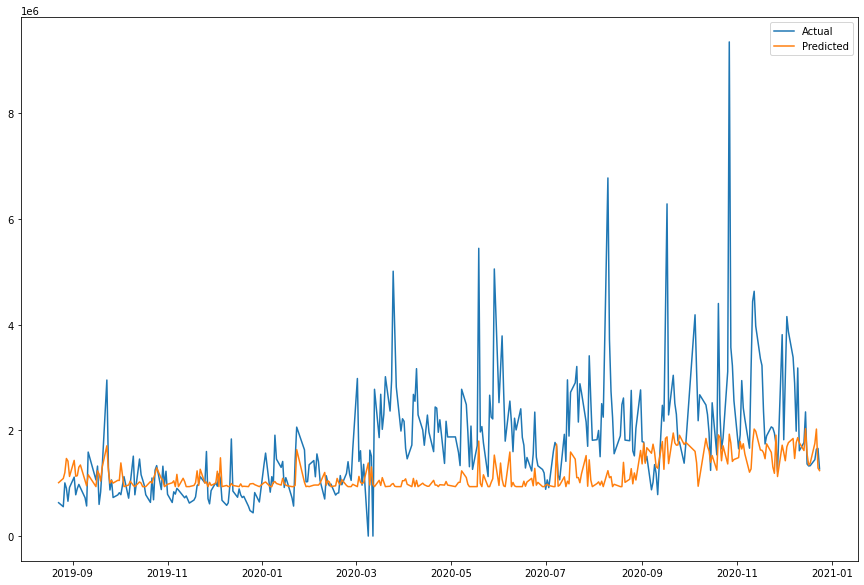

In [13]:
plt.figure(figsize=(15,10))
plt.plot(dates_test,y_test ,label="Actual")
plt.plot(dates_test,lassocv.predict(X_test),label="Predicted" )
plt.legend()
